# M044_2024_12_04_09_30

Session: M044_2024_12_04_09_30

In [42]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import pyaldata as pyal

from tools.dsp.preprocessing import preprocess
from tools.viz.rasters import plot_heatmap_raster
from tools.dsp.utils import sort_neurons_in_time_array


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# TODO: add example data to the repo and run on that
data_dir = r"C:\data\raw\M044\M044_2024_12_04_09_30"
fname = os.path.join(data_dir, "M044_2024_12_04_09_30_pyaldata.mat")

In [4]:
# load TrialData .mat file into a DataFrame
df = pyal.mat2dataframe(fname, shift_idx_fields=True)

field values_before_camera_trigger could not be converted to int.
field idx_before_camera_trigger could not be converted to int.
array field all_KSLabel could not be converted to int.


## Preprocessing from utils

In [5]:
df_ = preprocess(df)

c:\Users\MartinEsparzaINBRAIN\AppData\Local\pypoetry\Cache\virtualenvs\earthquake-analysis-dAG31IpV-py3.12\Lib\site-packages\pyaldata\firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(


Combined every 3 bins
Resulting all_spikes ephys data shape is (NxT): (474, 133)


## Preprocessing

In [184]:
time_signals = ['CP_spikes', 'MOp_spikes']
for signal in time_signals:
    df_ = pyal.remove_low_firing_neurons(df, signal, 1)  # Remove low firing (below 1 Hz) spikes from each spike trace 

C:\Users\MartinEsparzaINBRAIN\AppData\Local\pypoetry\Cache\virtualenvs\earthquake-analysis-dAG31IpV-py3.12\Lib\site-packages\pyaldata\firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(
C:\Users\MartinEsparzaINBRAIN\AppData\Local\pypoetry\Cache\virtualenvs\earthquake-analysis-dAG31IpV-py3.12\Lib\site-packages\pyaldata\firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(


In [186]:
df_ = pyal.merge_signals(df_, time_signals, 'MOp_CP_spikes')
df_.MOp_CP_spikes[0].shape

(60001, 442)

In [187]:
df_ = pyal.select_trials(df_, "trial_name == 'trial'")  # Remove baseline
df_ = pyal.select_trials(df_, "idx_trial_end > 90000")  # Remove first 5 minutes because the switch was off
df_ = pyal.select_trials(df_, "idx_trial_end > 90000")  # Remove first 5 minutes because the switch was off

In [188]:
df_.head().idx_trial_end

0    91099
1    91599
2    92299
3    93199
4    93699
Name: idx_trial_end, dtype: int64

In [189]:
BIN_SIZE = 0.03
df_ = pyal.combine_time_bins(df_, int(BIN_SIZE/.01))  # Pass it to times bins of 0.03

In [191]:
print("original: ", df.MOp_spikes[2].shape)
print("combined: ", df_.MOp_CP_spikes[0].shape)

original:  (401, 578)
combined:  (133, 442)


### Why sqrt the data?
Data from a poisson process have heteroscedasticity --> Unequal variance across different firing rates. The square root transformation stabilizes the variance because the variance of a Poisson process becomes approximately constant after applying this transformation. This makes the data more suitable for statistical analyses that assume homoscedasticity.

In [192]:
time_signals = [signal for signal in pyal.get_time_varying_fields(df_) if 'spikes' in signal]
for signal in time_signals:
    df_ = pyal.sqrt_transform_signal(df_, signal)

In [193]:
df_ = pyal.add_firing_rates(df_, 'smooth', std=0.05)

In [194]:
df_.head()

,animal,session,trial_id,trial_name,trial_length,bin_size,idx_trial_start,idx_trial_end,idx_CPI,values_before_camera_trigger,...,CP_spikes,MOp_chan_best,MOp_KSLabel,MOp_spikes,MOp_CP_spikes,scwm_rates,ccb_rates,CP_rates,MOp_rates,MOp_CP_rates
0,M044,M044_2024_12_04_09_30,82,trial,401,0.03,30233,30366,[],[],...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 67, 6...","[good, mua, mua, good, good, good, good, good,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.00031967516, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21239205, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.034771092, 0.0, 0.0, 0.0, 23.380...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,M044,M044_2024_12_04_09_30,84,trial,401,0.03,30399,30533,[],[],...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 67, 6...","[good, mua, mua, good, good, good, good, good,...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[6.201384, 6.201384, 2.798774, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 2.798774, 0.0, 3.0111659, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9141243...","[[1.1265163, 0.0, 0.0, 16.662374, 0.0, 9.03492...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9141243..."
2,M044,M044_2024_12_04_09_30,86,trial,401,0.03,30633,30766,[],[],...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 67, 6...","[good, mua, mua, good, good, good, good, good,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.91412437, 0.0, 2.833545, 0....","[[2.8027468, 25.524176, 0.0, 0.0, 0.0, 0.0, 0....","[[0.0, 0.0, 10.460135, 8.7700815, 0.0, 0.03477...","[[2.8027468, 25.524176, 0.0, 0.0, 0.0, 0.0, 0...."
3,M044,M044_2024_12_04_09_30,88,trial,401,0.03,30933,31066,[],[],...,"[[0.0, 1.4142135623730951, 0.0, 0.0, 0.0, 0.0,...","[66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 67, 6...","[good, mua, mua, good, good, good, good, good,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 1.4142135623730951, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.00031967516, 0.0,...","[[0.0, 18.313324, 0.034771092, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 3.712898, 0.0, 0.21239205, 0.0, 0....","[[0.0, 18.313324, 0.034771092, 0.0, 0.0, 0.0, ..."
4,M044,M044_2024_12_04_09_30,90,trial,401,0.03,31099,31233,[],[],...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 67, 6...","[good, mua, mua, good, good, good, good, good,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.91412437, 0.0, 0.0, 32.1682...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


## Plotting

In [7]:
df_ = pyal.select_trials(df_, "idx_trial_end > 30365")  # Remove first 5 minutes because the switch was off

In [21]:
df_.head()

,animal,session,trial_id,trial_name,trial_length,bin_size,idx_trial_start,idx_trial_end,idx_CPI,values_before_camera_trigger,...,values_Sol_duration,idx_Sol_duration,idx_sol_on,idx_earthquake_duration,idx_session_timer,all_chan_best,all_unit_guide,all_KSLabel,all_spikes,all_rates
0,M044,M044_2024_12_04_09_30,82,trial,401,0.03,30233,30366,[],[],...,50,-1,66,[],[],"[0, 0, 0, 1, 1, 1, 2, 3, 3, 3, 3, 3, 5, 5, 5, ...","[[0, 1], [5, 1], [5, 3], [6, 2], [8, 2], [9, 1...","[good, mua, good, mua, good, good, good, good,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 2.798774, 0.0, 0.91412437, 0...."
1,M044,M044_2024_12_04_09_30,84,trial,401,0.03,30399,30533,[],[],...,50,-1,66,[],[],"[0, 0, 0, 1, 1, 1, 2, 3, 3, 3, 3, 3, 5, 5, 5, ...","[[0, 1], [5, 1], [5, 3], [6, 2], [8, 2], [9, 1...","[good, mua, good, mua, good, good, good, good,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.003973114, 0.0, 0.0, 0.0, 0.91444397,..."
2,M044,M044_2024_12_04_09_30,86,trial,401,0.03,30633,30766,[],[],...,100,-1,66,[],[],"[0, 0, 0, 1, 1, 1, 2, 3, 3, 3, 3, 3, 5, 5, 5, ...","[[0, 1], [5, 1], [5, 3], [6, 2], [8, 2], [9, 1...","[good, mua, good, mua, good, good, good, good,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[25.524176, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000319..."
3,M044,M044_2024_12_04_09_30,88,trial,401,0.03,30933,31066,[],[],...,150,-1,66,[],[],"[0, 0, 0, 1, 1, 1, 2, 3, 3, 3, 3, 3, 5, 5, 5, ...","[[0, 1], [5, 1], [5, 3], [6, 2], [8, 2], [9, 1...","[good, mua, good, mua, good, good, good, good,...","[[1.4142135623730951, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[18.313324, 0.0, 0.0, 0.003973114, 0.0, 0.0, ..."
4,M044,M044_2024_12_04_09_30,90,trial,401,0.03,31099,31233,[],[],...,200,-1,66,[],[],"[0, 0, 0, 1, 1, 1, 2, 3, 3, 3, 3, 3, 5, 5, 5, ...","[[0, 1], [5, 1], [5, 3], [6, 2], [8, 2], [9, 1...","[good, mua, good, mua, good, good, good, good,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.24716315, 0...."


In [10]:
df_['all_chan_best'][0]

array([  0,   0,   0,   1,   1,   1,   2,   3,   3,   3,   3,   3,   5,
         5,   5,   5,   6,   6,   7,   8,   8,   8,   9,   9,   9,   9,
         9,  11,  11,  11,  12,  12,  13,  14,  14,  14,  14,  15,  15,
        15,  16,  17,  17,  17,  17,  18,  18,  18,  18,  19,  19,  20,
        20,  21,  21,  21,  21,  21,  22,  22,  22,  22,  23,  23,  25,
        25,  25,  26,  26,  26,  27,  27,  28,  28,  28,  29,  29,  29,
        30,  30,  30,  30,  31,  31,  32,  32,  33,  33,  33,  33,  34,
        34,  34,  34,  34,  35,  36,  36,  37,  37,  37,  37,  38,  38,
        38,  38,  38,  38,  38,  38,  39,  39,  39,  40,  40,  40,  41,
        41,  41,  41,  41,  42,  42,  42,  43,  43,  43,  43,  43,  44,
        44,  45,  45,  45,  46,  46,  46,  47,  47,  47,  48,  48,  49,
        49,  50,  50,  51,  51,  51,  52,  52,  52,  52,  53,  53,  53,
        53,  53,  53,  54,  54,  54,  54,  54,  54,  54,  54,  54,  55,
        55,  55,  55,  55,  55,  56,  56,  57,  57,  57,  57,  5

In [75]:
100 / 0.03

3333.3333333333335

- Trial 90 has some nice spikes

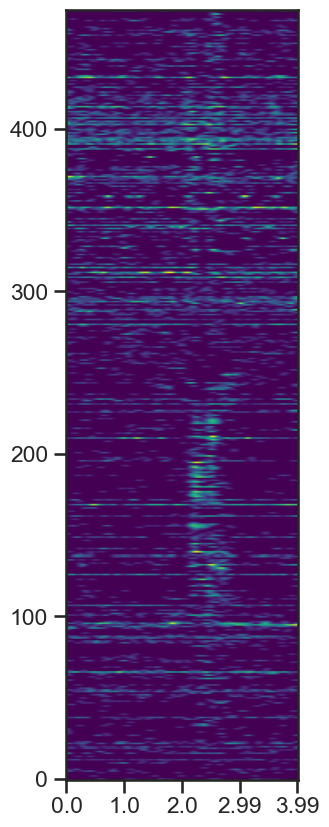

In [51]:
trial = 65
arr = df_[f"all_rates"][trial].T
with plt.style.context("seaborn-v0_8-bright"):
    sns.set_theme(context="talk", style="ticks", font="Arial")
    fig, ax = plt.subplots(sharex="all", figsize=(3, 10))
    ax = plot_heatmap_raster(arr, show=False, ax=ax, num_ticks=5)
    plt.show()


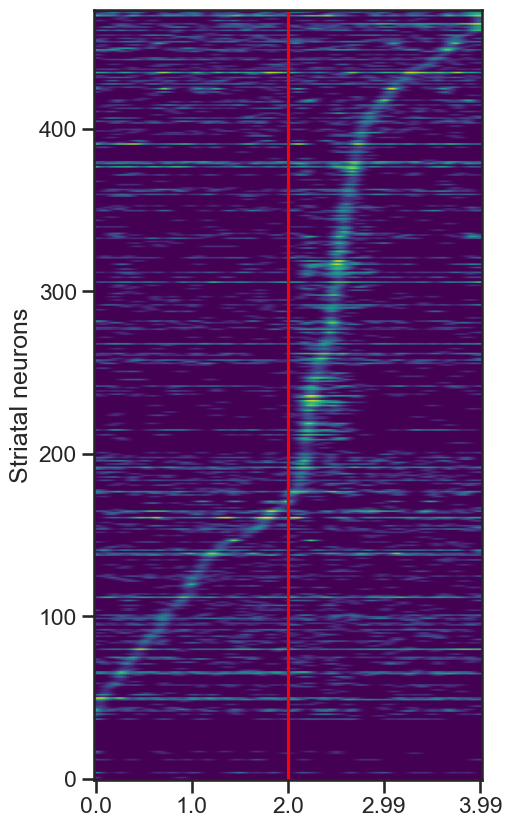

In [56]:
z_scored_array = sort_neurons_in_time_array(arr[:, :])
with plt.style.context("seaborn-v0_8-bright"):
    sns.set_theme(context="talk", style="ticks", font="Arial")
    fig, ax = plt.subplots(sharex="all", figsize=(5, 10))
    ax = plot_heatmap_raster(z_scored_array, show=False, ax=ax, num_ticks=5)
    ax.axvline(x=66, color="red")
    ax.set_ylabel("Striatal neurons")
    plt.show()


In [57]:
arr_concat_trials = pyal.concat_trials(df_, "all_spikes")
arr_concat_trials.shape

(65569, 474)

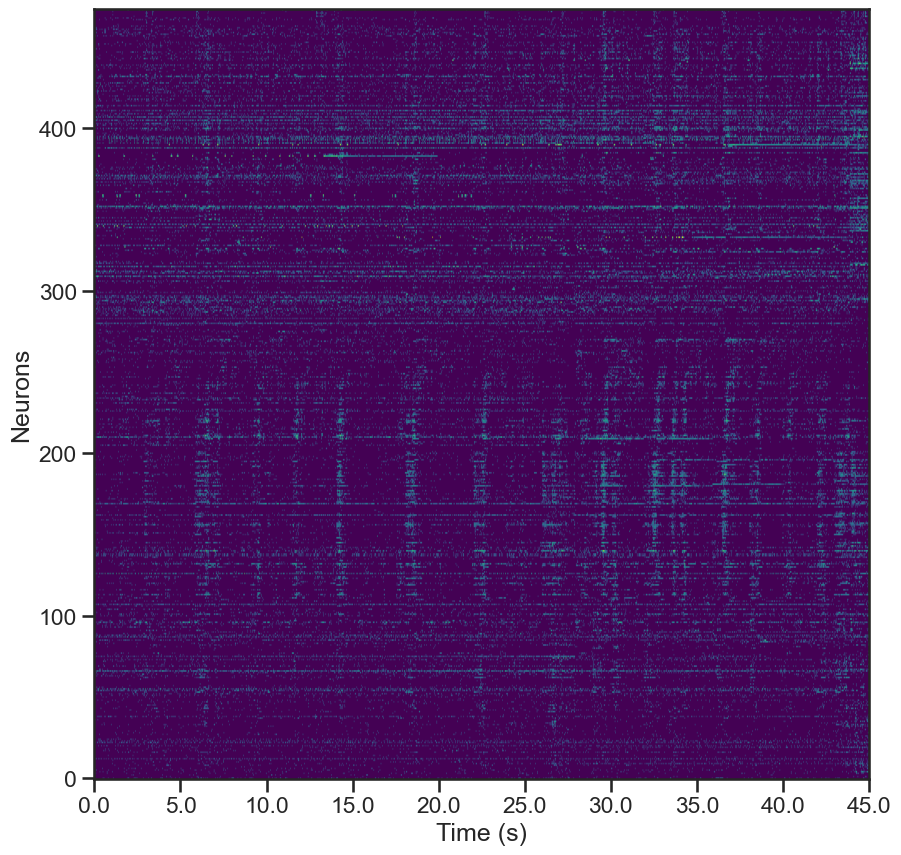

In [58]:
with plt.style.context("seaborn-v0_8-bright"):
    sns.set_theme(context="talk", style="ticks", font="Arial")
    fig, ax = plt.subplots(sharex="all", figsize=(10, 10))
    ax = plot_heatmap_raster(arr_concat_trials[:1500, :].T, show=False, ax=ax)
    ax.set_ylabel("Neurons")
    ax.set_xlabel("Time (s)")
    plt.show()
